Pedro Jorge Oliveira Câmara - DRE: 120182069

As partes teóricas estão no outro pdf!

### Imports e definições

In [ ]:
import Pkg;
Pkg.add("Plots")
Pkg.add("GaussQuadrature")
Pkg.add("SparseArrays")
Pkg.add("DataFrames")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [ ]:
using LinearAlgebra
using Plots
using GaussQuadrature
using SparseArrays
using DataFrames

# definições das constantes utilizadas
α = 1
β = 1
γ = 1

u_0 = 0
u_1 = 0

x_min = 0
x_max = 1


# definição das funções u, f
function u(x)
    return sin(π*x)
end


function f(x)
    return (α*π^2 + β)*sin(π*x) + γ*π*cos(π*x)
end

f (generic function with 1 method)

### Galerkin e Matriz-Vetor

#### Definições de $\varphi$ e $\frac{d \varphi}{d \xi}$

In [ ]:
function φ(ξ, a)
    if a == 1
        return (1-ξ) / 2
    elseif a == 2
        return (1+ξ) / 2
    end

    return nothing
end


function dφ(ξ, a)
    if a == 1
        return -1/2
    elseif a == 2
        return 1/2
    end

    return nothing
end


dφ (generic function with 1 method)

#### Montagem da matriz e do vetor locais

Cálculo da matriz local $K^e$ via quadratura gaussiana

In [ ]:
function get_K_e(h)
    # A e B são as constantes da equação da K local via quadratura gaussiana
    # respectivamente as constantes do primeiro e segundo termo da equação
    A = 2*α/h
    B = β*h/2

    # dois pontos para a quadratura
    n_points = 2
    P, W = legendre(n_points)

    K_e = zeros(2, 2)

    for a = 1:2
        for b = 1:2
            for j = 1:n_points
                # operação diretamente da equação da K local
                K_e[a, b] += W[j] * (A*dφ(P[j], b)*dφ(P[j], a) + B*φ(P[j], b)*φ(P[j], a) + γ*dφ(P[j], b)*φ(P[j], a))
            end
        end
    end

    return K_e
end



get_K_e (generic function with 1 method)

Cálculo do vetor local $F^e$ via quadratura gaussiana

In [ ]:
# faz o mapeamento da troca de variável de ξ para x
function x_from_ξ(ξ, h, x1e)
    return (ξ+1) * h/2 + x1e
end

function get_F_e(h, x1e, P, W)
    F_e = zeros(2)

    for a = 1:2
        for j in 1:length(P)
            x = x_from_ξ(P[j], h, x1e)
            # operação diretamente da equação do F local
            F_e[a] += (h/2) * W[j] * f(x) * φ(P[j], a)
        end
    end

    return F_e
end

get_F_e (generic function with 1 method)

#### Montagem da matriz e do vetor globais

Funções que calculam a matriz $LG$ e o vetor $EQ$

In [ ]:
# monta a matriz LG pela sua definição
# [1 2 ... n_elements]
# [2 3 ... n_elements+1]
function get_LG(n_elements)
    return transpose(hcat(1:n_elements, 2:n_elements+1))
end


# monta o vetor EQ pela sua definição
# [m+1 1 2 ... m+1] com m = n_elements-1
function get_EQ(n_elements)
    m = n_elements-1
    EQ = vcat(m+1, 1:m, m+1)

    return m, EQ
end

get_EQ (generic function with 1 method)

Cálculo da matriz $K$ global

In [ ]:
function get_K(n_elements, m, EQoLG)
    h = 1/n_elements

    K = spzeros(m+1, m+1)
    K_e = get_K_e(h)

    for e = 1:n_elements
        for a = 1:2
            i = EQoLG[a, e]
            for b = 1:2
                j = EQoLG[b, e]
                K[i, j] += K_e[a, b]
            end
        end
    end

    return K[1:m, 1:m]
end


get_K (generic function with 1 method)

Cálculo do vetor $F$ global

In [ ]:
function get_F(n_elements, m, EQoLG)
    h = 1/n_elements
    F = zeros(m+1)

    n_points = 5
    P, W = legendre(n_points)

    for e = 1:n_elements
        F_e = get_F_e(h, (e-1)*h, P, W)
        for a = 1:2
            i = EQoLG[a, e]
            F[i] += F_e[a]
        end
    end

    return F[1:m]
end


get_F (generic function with 1 method)

#### Erro $L2$

In [ ]:
function error_L2_norm(c, n_elements, EQoLG)
    h = 1/n_elements
    error = 0

    n_points = 5
    P, W = legendre(n_points)

    # aplica φ aos pontos de quadratura
    φ1P = φ.(P, 1)
    φ2P = φ.(P, 2)

    # calcula a equação do erro
    for e = 1:n_elements
        for j = 1:n_points
            x = x_from_ξ(P[j], h, (e-1)*h)
            error += W[j] * (u(x) - c[EQoLG[1,e]]*φ1P[j] - c[EQoLG[2, e]]*φ2P[j])^2
        end
    end

    return sqrt(h/2 * error)
end

error_L2_norm (generic function with 1 method)

#### Resultados numéricos - Comparação

Utilizando $4$ elementos e $h = 1/4$

In [ ]:
n_elements = 4
h = 1/n_elements

LG = get_LG(n_elements)
m, EQ = get_EQ(n_elements)
EQoLG = EQ[LG]

K = get_K(n_elements, m, EQoLG)
F = get_F(n_elements, m, EQoLG)

c = K \ F

3-element Vector{Float64}:
 0.7137289051760546
 1.0053005170657479
 0.7076694368382578

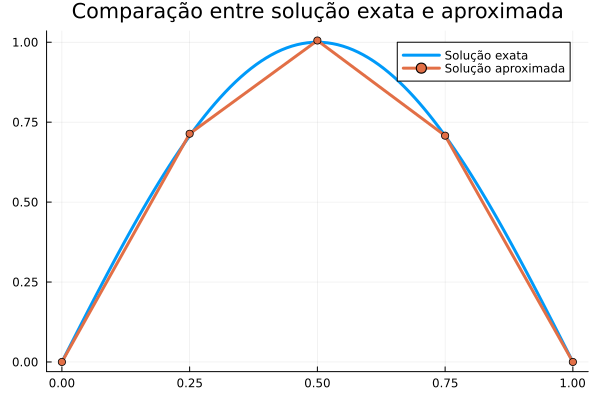

In [ ]:
x = x_min:0.01:x_max
malha = x_min:h:x_max

plt = plot(x, u.(x), label="Solução exata", lw=3, title="Comparação entre solução exata e aproximada")
plot!(plt, malha, [0; c; 0], label="Solução aproximada", lw=3, linestyle=:solid, markershape=:circle)

In [ ]:
K

3×3 SparseMatrixCSC{Float64, Int64} with 7 stored entries:
  8.16667  -3.45833    ⋅ 
 -4.45833   8.16667  -3.45833
   ⋅       -4.45833   8.16667

In [ ]:
F

3-element Vector{Float64}:
 2.352121770752068
 2.5805560513947237
 1.2973355955943129

#### Resultados numéricos - Erro

Erro entre a solução aproximada e a solução exata

In [ ]:
error_L2_norm([c; 0], n_elements, EQoLG)

0.036236897255589685

Estudo da convergência do erro

In [ ]:
function error_convergence()
    # lista com 2^2, 2^3, ..., 2^17
    vec_n_elements = [2^i for i = 2:17]
    # lista para guardar os erros de cada número de elementos de 2^2, 2^3, ..., 2^17
    vec_errors = zeros(length(vec_n_elements))

    # executa o método e guarda o erro associado para cada número de elementos
    for i = 1:length(vec_n_elements)
        n_elements = vec_n_elements[i]

        LG = get_LG(n_elements)
        m, EQ = get_EQ(n_elements)
        EQoLG = EQ[LG]

        K = get_K(n_elements, m, EQoLG)
        F = get_F(n_elements, m, EQoLG)

        c = K \ F

        vec_errors[i] = error_L2_norm([c; 0], n_elements, EQoLG)
    end

    vec_h = 1 ./ vec_n_elements

    display(DataFrame(h=vec_h, erro=vec_errors))

    plt = plot(vec_h, vec_errors, lw=3, linestyle=:solid, markershape=:circle, label="Erro", title="Estudo do erro no exemplo", xscale=:log10, yscale=:log10)
    plot!(plt, vec_h, vec_h.^2, lw=3, linestyle=:solid, label="h^2")
end


error_convergence (generic function with 1 method)

Row,h,erro
,Float64,Float64
1,0.25,0.0362369
2,0.125,0.00908283
3,0.0625,0.00227211
4,0.03125,0.000568114
5,0.015625,0.000142034
6,0.0078125,3.55088e-5
7,0.00390625,8.87722e-6
8,0.00195312,2.21931e-6
9,0.000976562,5.54838e-7


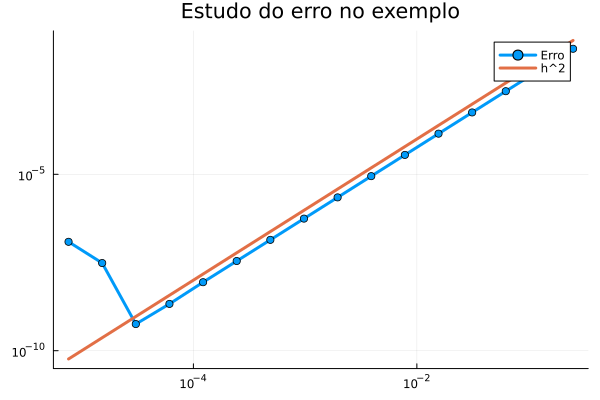

In [ ]:
error_convergence()

# Equação do calor

In [ ]:
function get_C_0!(C_0, u_0, n_elements, m, EQoLG, method)
  if method == 1
    h = 1/n_elements
    @. C_0 = u_0(h:h:1-h)
  elseif method == 2
    C_0 .= get_K(n_elements, m, EQoLG)
  end
end

get_C_0! (generic function with 1 method)

In [ ]:
function get_C_n!(C_n, C_n_, A, B, n_elements, m, EQoLG, τ, n, f)

end

τ